In [1]:
!pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
!pip install -U nltk

Writing to /home/mw/.config/pip/pip.conf
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
!mkdir /home/mw/project/coco2014
!ln -s /home/mw/input/020614521/test2014/test2014 /home/mw/project/coco2014
!ln -s /home/mw/input/02066579/val2014/* /home/mw/project/coco2014
!ln -s /home/mw/input/020628093/train2014-1/train2014-1 /home/mw/project/coco2014
!ln -s /home/mw/input/020631458/train2014-2/train2014-2 /home/mw/project/coco2014

mkdir: cannot create directory ‘/home/mw/project/coco2014’: File exists
ln: failed to create symbolic link '/home/mw/project/coco2014/test2014': File exists
ln: failed to create symbolic link '/home/mw/project/coco2014/val2014': File exists
ln: failed to create symbolic link '/home/mw/project/coco2014/train2014-1': File exists
ln: failed to create symbolic link '/home/mw/project/coco2014/train2014-2': File exists


In [3]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.backends.cudnn as cudnn
from models import Encoder, DecoderWithRNN, DecoderWithAttention
from datasets import *
from solver import *

In [4]:
cfg = {
    # Data parameters
    'data_folder' : '/home/mw/work/work_dir',  
    'data_name' : 'coco_5_cap_per_img_5_min_word_freq',  # base name shared by data files
    # Model parameters
    'embed_dim' : 512,  # dimension of word embeddings
    'attention_dim' : 512,  # dimension of attention linear layers
    'decoder_dim' : 512,  # dimension of decoder RNN
    'dropout' : 0.5,
    'device' : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),  # sets device for model and PyTorch tensors
    # Training parameters
    'start_epoch' : 0,
    'epochs' : 10,  # number of epochs to train for (if early stopping is not triggered)
    'epochs_since_improvement' : 0,  # keeps track of number of epochs since there's been an improvement in validation BLEU
    'batch_size' : 32,
    'workers' : 1,  # for data-loading; right now, only 1 works with h5py
    'encoder_lr' : 1e-4,  # learning rate for encoder if fine-tuning
    'decoder_lr' : 4e-4,  # learning rate for decoder
    'grad_clip' : 5.,  # clip gradients at an absolute value of
    'alpha_c' : 1.,  # regularization parameter for 'doubly stochastic attention', as in the paper
    'best_bleu4' : 0.,  # BLEU-4 score right now
    'print_freq' : 100,  # print training/validation stats every __ batches
    'fine_tune_encoder' : False,  # fine-tune encoder or not
    'checkpoint' : None,  # path to checkpoint, None if none
    'attention' : True, # train decoder with attention or not
}
cudnn.benchmark = True  # set to true only if inputs to model are fixed size; otherwise lot of computational overhead

In [5]:
word_map_file = os.path.join(cfg['data_folder'], 'WORDMAP_' + cfg['data_name'] + '.json')
with open(word_map_file, 'r') as j:
    word_map = json.load(j)
cfg['vocab_size'] = len(word_map)

In [6]:
os.environ['TORCH_HOME'] = '/home/mw/work/work_dir/coco2014'

In [7]:
if cfg['checkpoint'] is None:
    encoder = Encoder()
    encoder.fine_tune(cfg['fine_tune_encoder'])
    encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                         lr=cfg['encoder_lr']) if cfg['fine_tune_encoder'] else None
    if not cfg['attention']:
        decoder = DecoderWithRNN(cfg)
    else:
        decoder = DecoderWithAttention(cfg)
    decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                                         lr=cfg['decoder_lr'])
else:
    checkpoint = torch.load(cfg['checkpoint'])
    cfg['start_epoch'] = checkpoint['epoch'] + 1
    cfg['epochs_since_improvement'] = checkpoint['epochs_since_improvement']
    cfg['best_bleu4'] = checkpoint['bleu-4']
    encoder = checkpoint['encoder']
    encoder_optimizer = checkpoint['encoder_optimizer']
    decoder = checkpoint['decoder']
    decoder_optimizer = checkpoint['decoder_optimizer']
    if cfg['fine_tune_encoder'] is True and encoder_optimizer is None:
        encoder.fine_tune(cfg['fine_tune_encoder'])
        encoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, encoder.parameters()),
                                             lr=cfg['encoder_lr'])

In [8]:
# Move to GPU, if available
decoder = decoder.to(cfg['device'])
encoder = encoder.to(cfg['device'])

In [9]:
# Loss function
criterion = nn.CrossEntropyLoss().to(cfg['device'])

In [10]:
# Custom dataloaders
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_loader = torch.utils.data.DataLoader(
    CaptionDataset(cfg['data_folder'], cfg['data_name'], 'TRAIN', transform=transforms.Compose([normalize])),
    batch_size=cfg['batch_size'], shuffle=True, num_workers=cfg['workers'], pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    CaptionDataset(cfg['data_folder'], cfg['data_name'], 'VAL', transform=transforms.Compose([normalize])),
    batch_size=cfg['batch_size'], shuffle=True, num_workers=cfg['workers'], pin_memory=True)

In [11]:
# Epochs
for epoch in range(cfg['start_epoch'], cfg['epochs']):

    # Decay learning rate if there is no improvement for 8 consecutive epochs, and terminate training after 20
    if cfg['epochs_since_improvement'] == 20:
        break
    if cfg['epochs_since_improvement'] > 0 and cfg['epochs_since_improvement'] % 8 == 0:
        adjust_learning_rate(decoder_optimizer, 0.8)
        if cfg['fine_tune_encoder']:
            adjust_learning_rate(encoder_optimizer, 0.8)

    # One epoch's training
    train(train_loader=train_loader,
          encoder=encoder,
          decoder=decoder,
          criterion=criterion,
          encoder_optimizer=encoder_optimizer,
          decoder_optimizer=decoder_optimizer,
          epoch=epoch,
          cfg=cfg)
    
    # One epoch's validation
    recent_bleu4 = validate(val_loader=val_loader,
                            encoder=encoder,
                            decoder=decoder,
                            criterion=criterion,
                            word_map=word_map,
                            cfg=cfg)

    # Check if there was an improvement
    is_best = recent_bleu4 > cfg['best_bleu4']
    cfg['best_bleu4'] = max(recent_bleu4, cfg['best_bleu4'])
    if not is_best:
        cfg['epochs_since_improvement'] += 1
        print("\nEpochs since last improvement: %d\n" % (cfg['epochs_since_improvement'],))
    else:
        cfg['epochs_since_improvement'] = 0

    # Save checkpoint
    save_checkpoint(cfg['data_name'], epoch, cfg['epochs_since_improvement'], encoder, decoder, encoder_optimizer,
                    decoder_optimizer, recent_bleu4, is_best)

/home/mw/project/models.py:203: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  alpha = F.softmax(e)
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: [0][0/17702]	Batch Time 1.410 (1.410)	Data Load Time 0.265 (0.265)	Loss 10.1272 (10.1272)	Top-5 Accuracy 0.000 (0.000)
Epoch: [0][100/17702]	Batch Time 0.372 (0.357)	Data Load Time 0.000 (0.003)	Loss 6.0618 (6.6365)	Top-5 Accuracy 38.315 (34.350)
Epoch: [0][200/17702]	Batch Time 0.383 (0.357)	Data Load Time 0.000 (0.002)	Loss 5.2919 (6.2037)	Top-5 Accuracy 46.809 (37.952)
Epoch: [0][300/17702]	Batch Time 0.349 (0.356)	Data Load Time 0.000 (0.001)	Loss 5.1142 (5.9215)	Top-5 Accuracy 50.549 (41.230)
Epoch: [0][400/17702]	Batch Time 0.356 (0.356)	Data Load Time 0.000 (0.001)	Loss 4.4512 (5.7220)	Top-5 Accuracy 58.747 (43.567)
Epoch: [0][500/17702]	Batch Time 0.350 (0.355)	Data Load Time 0.000 (0.001)	Loss 4.7625 (5.5699)	Top-5 Accuracy 53.388 (45.513)
Epoch: [0][600/17702]	Batch Time 0.341 (0.355)	Data Load Time 0.000 (0.001)	Loss 4.7142 (5.4502)	Top-5 Accuracy 56.948 (47.098)
Epoch: [0][700/17702]	Batch Time 0.336 (0.354)	Data Load Time 0.000 (0.001)	Loss 4.6704 (5.3507)	Top-5 Acc

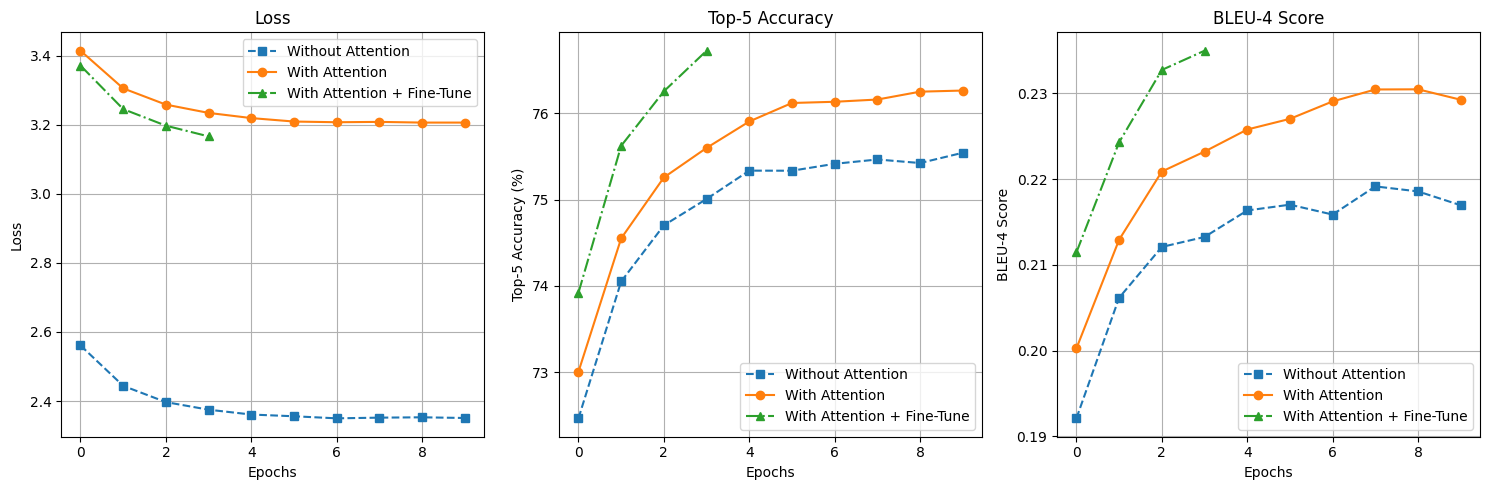

In [5]:
import matplotlib.pyplot as plt

# 带attention机制的数据
loss_attention = [3.414, 3.305, 3.258, 3.234, 3.219, 3.209, 3.207, 3.208, 3.206, 3.206]
top5_accuracy_attention = [73.007, 74.551, 75.256, 75.598, 75.904, 76.118, 76.132, 76.158, 76.249, 76.262]
bleu4_attention = [0.20026115980658207, 0.2129326655784661, 0.220877622883263, 0.2232005371638974, 0.22577627017891636, 0.22701703762313327, 0.22905155826158327, 0.23044049990411558, 0.23045871177259478, 0.2292431787310961]

# 不带attention机制的数据
loss_no_attention = [2.561, 2.444, 2.397, 2.375, 2.361, 2.356, 2.350, 2.352, 2.353, 2.351]
top5_accuracy_no_attention = [72.468, 74.052, 74.702, 75.007, 75.335, 75.334, 75.414, 75.464, 75.423, 75.542]
bleu4_no_attention = [0.19211562851102434, 0.206167972668384, 0.21208995512435172, 0.2132522999078148, 0.21634075906470107, 0.21701614735505384, 0.21586192777255203, 0.21914566402602026, 0.2185600676157566, 0.21694456413193874]

# 在Attention基础上加上fine-tune的数据
loss_fine_tune = [3.371, 3.245, 3.197, 3.166]
top5_accuracy_fine_tune = [73.921, 75.622, 76.253, 76.723]
bleu4_fine_tune = [0.21145163883000279, 0.2242869197515953, 0.2327172001811528, 0.23495777605616544]

# 绘制折线图
plt.figure(figsize=(15, 5))

# LOSS 折线图
plt.subplot(1, 3, 1)
plt.plot(loss_no_attention, marker='s', linestyle='--', label='Without Attention')
plt.plot(loss_attention, marker='o', linestyle='-', label='With Attention')
plt.plot(loss_fine_tune, marker='^', linestyle='-.', label='With Attention + Fine-Tune')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# TOP-5 ACCURACY 折线图
plt.subplot(1, 3, 2)
plt.plot(top5_accuracy_no_attention, marker='s', linestyle='--', label='Without Attention')
plt.plot(top5_accuracy_attention, marker='o', linestyle='-', label='With Attention')
plt.plot(top5_accuracy_fine_tune, marker='^', linestyle='-.', label='With Attention + Fine-Tune')
plt.title('Top-5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top-5 Accuracy (%)')
plt.legend()
plt.grid(True)

# BLEU-4 折线图
plt.subplot(1, 3, 3)
plt.plot(bleu4_no_attention, marker='s', linestyle='--', label='Without Attention')
plt.plot(bleu4_attention, marker='o', linestyle='-', label='With Attention')
plt.plot(bleu4_fine_tune, marker='^', linestyle='-.', label='With Attention + Fine-Tune')
plt.title('BLEU-4 Score')
plt.xlabel('Epochs')
plt.ylabel('BLEU-4 Score')
plt.legend()
plt.grid(True)

# 调整子图间距
plt.tight_layout()

# 显示图表
plt.show()